In [1]:
%matplotlib inline
import os
os.chdir("..")
import matplotlib.pyplot as plt
import sys
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import TruncatedSVD
import os
from math import log
import random
import time
import pickle
from numpy.linalg import pinv
from arm_class import ArmGaussian
from LinTS_class import PolicyLinTS
from LinUCB_class import PolicyLinUCB
from D_LinUCB_class import DLinUCB
from D_LinTS_class import DLinTS
from D_RandLinUCB_class import DRandLinUCB
from environment_class import Environment
from simulator_class import Simulator
from utils import plot_regret

In [2]:
#Input Parameters
d = 20  # dimension
k = 50  # number of arms / 2

In [3]:
#Load Criteo Dataset
seed = 1
DATA_FILE='criteo_attribution_dataset.tsv.gz'
df = pd.read_csv(DATA_FILE, sep='\t', compression='gzip')
df_sub = df.sample(n=200000, random_state=seed)
FEATURES = ['campaign', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8', 'cat9']
df_onehot = df_sub.click
for index in FEATURES:
    df_add = pd.get_dummies(df_sub[index])
    df_onehot = pd.concat([df_onehot, df_add], axis=1)
df_onehot.drop(['click'], axis=1)
svd = TruncatedSVD(d)
reduced = svd.fit_transform(df_onehot)
print(reduced.shape)

(200000, 20)


In [4]:
#Manipulating Dataset for Experiment
df_reduced = pd.DataFrame(data = reduced)
X = df_reduced
y = 2*df_sub.click-1
reg = LinearRegression().fit(X, y)
print(reg.intercept_)
print(reg.coef_)
coef = reg.coef_
s = np.linalg.norm(coef)
print(s)
df_not_click = df_reduced[(df_sub.click == 0).tolist()].sample(n=10000, random_state=seed)
df_click = df_reduced[(df_sub.click == 1).tolist()].sample(n=10000, random_state=seed)
m1 = np.max(np.sqrt(np.square(df_not_click).sum(axis=1)))
m2 = np.max(np.sqrt(np.square(df_click).sum(axis=1)))
l = np.max([m1,m2])
print(l)

-1.143426517778203
[ 5.44286603e-01 -3.17624171e-02  4.68544651e-01  1.35494055e-01
  9.34583468e-01  1.24822377e+00 -9.68857703e-01  7.46779526e-02
  1.59397936e-01 -1.45136119e-01 -1.79895596e-02  8.59461537e-02
  6.80480602e-04  3.06513622e-02 -2.07302920e-02 -1.25907589e-01
  4.59188589e-02 -4.13409115e-02  2.03969035e-03  1.22674591e-02]
1.9965714688894565
3.004955448043454


In [5]:
# General parameters
delta = 0.01 # Probability of being outside the confidence interval
lambda_ = 1 # Regularisation parameter
q = 10 # Diplaying the quantile (in %)
steps = 10000  # number of steps for the experiment
n_scat = 1000 # How frequently should we plot the true parameter
t_saved = None
alpha = 1
sigma_noise = np.sqrt(0.15) # Square root of the variance of the noise
verbose = False

In [6]:
# Simulator Functions
def experiment_policies(n_mc):
    mab = Environment(d, theta, sigma_noise, verbose, None, df_click, df_not_click)
    simulator = Simulator(mab, theta, policies, k, d, steps, bp, verbose)
    avgRegret, qRegret, QRegret = simulator.run(steps, n_mc, q, n_scat, t_saved)
    return avgRegret, qRegret, QRegret

def data_from_experiment(n_mc):
    avgRegret, qRegret, QRegret = experiment_policies(n_mc)
    data = [[policy, avgRegret[policy], qRegret[policy],
            QRegret[policy]] for policy in avgRegret]
    return data

In [7]:
### Description of the experiment
np.random.seed(seed)
theta = coef # Starting point of the true unknown parameter
print(theta.astype)
flip = 2*np.random.binomial(1,0.4,d)-1
print(flip.astype)
theta_flip = np.multiply(flip, theta)

bp = {4001: theta_flip} # Descrition of the breakpoints
B_T = np.linalg.norm(theta - theta_flip) # Computed manually
print('B_T value:', B_T)
print('Sigma value for the experimenxt:', sigma_noise)

gamma  = 1 - (B_T/(d*steps))**(2/3) # Optimal Value to minimize the asymptotical regret
tau = (d*steps/B_T)**(2/3) # Optimal Value to minimize the asymptotical regret
print('gamma:', gamma)
print('tau:', tau)

policies = [
            DLinUCB(d, delta, alpha, lambda_, s, l, gamma, '', sm = False, sigma_noise = sigma_noise, verbose=verbose),
            DLinTS(d, delta, alpha, lambda_, s, l, gamma, '', sm = False, sigma_noise = sigma_noise, verbose=verbose),
            DRandLinUCB(d, delta, alpha/2.5, lambda_, s, l, gamma, '', sm = False, sigma_noise = sigma_noise, verbose=verbose, option = "couple_opt"),
            #PolicyLinUCB(d, delta, alpha, lambda_, s, l, '', sm = True, sigma_noise = sigma_noise, verbose=verbose),
            #PolicyLinUCB(d, delta, alpha, lambda_, s, l, '-OR', sm = True, sigma_noise = sigma_noise, verbose=verbose, omniscient = True),
            PolicyLinTS(d, delta, alpha, lambda_, s, l, '', sm = True, sigma_noise = sigma_noise, verbose=verbose),
            PolicyLinTS(d, delta, alpha, lambda_, s, l, '-OR', sm = True, sigma_noise = sigma_noise, verbose=verbose, omniscient = True)
           ]

<built-in method astype of numpy.ndarray object at 0x7fd74047c620>
<built-in method astype of numpy.ndarray object at 0x7fd2b21f11c0>
B_T value: 3.9805074103346003
Sigma value for the experimenxt: 0.3872983346207417
gamma: 0.9992655893591226
tau: 1361.63604438692


# Unparallelized experiments

In [8]:
data= data_from_experiment(n_mc=100)

100%|██████████| 100/100 [3:21:49<00:00, 107.96s/it] 


-- Building data out of the experiments ---
--- Data built ---


In [9]:
import pickle
with open('20dim_100arms', 'wb') as f:
    pickle.dump(data, f)

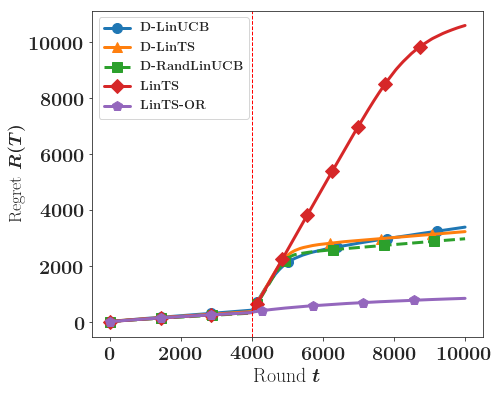

In [10]:
plot_regret(data, t_saved, filename = None, log=False, qtl=False, loc=2, font=13, bp = bp, bp_2 = {})

In [11]:
plot_regret(data, t_saved, filename = 'figure_100arms_20dim', log=False, qtl=False, loc=2, font=13, bp = bp, bp_2 = {})